=============================================================================
MODELO XGBOOST OPTIMIZADO - DETECCIÓN DE ODIO (DATASET PEQUEÑO)
=============================================================================
Técnicas específicas para datasets pequeños:
- Data Augmentation con backtranslation simulada
- SMOTE para balanceo sintético
- Regularización extrema
- Ensemble de modelos con diferentes seeds
- Feature engineering mejorado
=============================================================================

In [77]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from pathlib import Path
import joblib
import mlflow
import mlflow.xgboost
import mlflow.sklearn

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, classification_report, confusion_matrix
)
from scipy.sparse import hstack, csr_matrix
from imblearn.over_sampling import SMOTE

import xgboost as xgb
import optuna
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [78]:
# =============================================================================
# 1. CONFIGURACIÓN
# =============================================================================

RND = 42
np.random.seed(RND)

# Detectar si estamos en notebooks/
cwd = Path.cwd()
project_root = cwd.parent if "notebooks" in str(cwd) else cwd

data_path = project_root / "data" / "processed" / "youtube_all_versions.pkl"
models_dir = project_root / "models"
models_dir.mkdir(parents=True, exist_ok=True)

# MLflow
mlruns_dir = project_root / "mlruns"
mlruns_dir.mkdir(exist_ok=True)
mlflow.set_tracking_uri(f"file:///{mlruns_dir.as_posix()}")
mlflow.set_experiment("YouTube_Hate_XGBoost_Small_Dataset")

print("=" * 80)
print("🎯 DETECCIÓN DE MENSAJES DE ODIO - YOUTUBE (DATASET PEQUEÑO)")
print("=" * 80)
print(f"📂 Project root: {project_root}")
print(f"📂 Data path: {data_path}")

🎯 DETECCIÓN DE MENSAJES DE ODIO - YOUTUBE (DATASET PEQUEÑO)
📂 Project root: c:\Users\Administrator\Desktop\NLP\Proyecto_X_NLP_Equipo3
📂 Data path: c:\Users\Administrator\Desktop\NLP\Proyecto_X_NLP_Equipo3\data\processed\youtube_all_versions.pkl


In [79]:
# =============================================================================
# 2. CARGA Y ANÁLISIS DE DATOS
# =============================================================================

df = pd.read_pickle(data_path)
print(f"\n📊 Dataset: {df.shape[0]:,} filas, {df.shape[1]} columnas")

# Validar columnas esenciales
assert 'Text_Lemmatized' in df.columns and 'IsHate' in df.columns

# Features numéricas
numeric_features = [
    'char_count', 'word_count', 'sentence_count', 'avg_word_length',
    'uppercase_count', 'uppercase_ratio', 'exclamation_count', 
    'question_count', 'emoji_count', 'url_count', 'mention_count', 
    'hashtag_count', 'number_count'
]
feature_cols = [c for c in numeric_features if c in df.columns]
print(f"✅ Features numéricas: {len(feature_cols)}")

X_text = df['Text_Lemmatized'].astype(str)
X_num = df[feature_cols].fillna(0) if feature_cols else pd.DataFrame(index=df.index)
y = df['IsHate'].astype(int)

# Balance
print(f"\n📊 Balance de clases:")
balance = y.value_counts(normalize=True)
print(f"   Normal (0): {balance[0]*100:.1f}%")
print(f"   Odio (1):   {balance[1]*100:.1f}%")


📊 Dataset: 997 filas, 39 columnas
✅ Features numéricas: 13

📊 Balance de clases:
   Normal (0): 54.0%
   Odio (1):   46.0%


In [80]:
# =============================================================================
# 3. DATA AUGMENTATION INTELIGENTE (balancear, no desequilibrar)
# =============================================================================

minority_class = y.value_counts().idxmin()
majority_class = y.value_counts().idxmax()

n_minority = (y == minority_class).sum()
n_majority = (y == majority_class).sum()

print(f"\n🔄 Evaluando necesidad de Data Augmentation:")
print(f"   Clase minoritaria ({minority_class}): {n_minority}")
print(f"   Clase mayoritaria ({majority_class}): {n_majority}")
print(f"   Ratio: {n_minority/n_majority:.2f}")

# OBJETIVO: Llegar a ratio ~0.85-0.90 (no 1.0 para evitar sobreajuste)
if n_minority / n_majority < 0.85:
    # Calcular cuántos necesitamos para llegar a ratio 0.88
    target_ratio = 0.88
    n_augment = int(n_majority * target_ratio) - n_minority
    n_augment = max(0, n_augment)  # No negativos
    
    print(f"   🎯 Objetivo: ratio={target_ratio:.2f}")
    print(f"   Ejemplos a generar: {n_augment}")
    
    if n_augment > 0:
        minority_mask = (y == minority_class)
        minority_texts = X_text[minority_mask]
        minority_nums = X_num[minority_mask]
        minority_labels = y[minority_mask]
        
        aug_indices = np.random.choice(len(minority_texts), n_augment, replace=True)
        
        # Augmentation simple (solo duplicados, no modificamos texto)
        aug_texts = minority_texts.iloc[aug_indices].reset_index(drop=True)
        aug_nums = minority_nums.iloc[aug_indices].reset_index(drop=True)
        aug_labels = minority_labels.iloc[aug_indices].reset_index(drop=True)
        
        X_text_aug = pd.concat([X_text, aug_texts], ignore_index=True)
        X_num_aug = pd.concat([X_num, aug_nums], ignore_index=True)
        y_aug = pd.concat([y, aug_labels], ignore_index=True)
        
        print(f"   ✅ Aumentado: {len(y):,} → {len(y_aug):,} (+{n_augment} ejemplos)")
        print(f"   Balance final:")
        for cls, count in y_aug.value_counts().items():
            print(f"      Clase {cls}: {count} ({count/len(y_aug)*100:.1f}%)")
    else:
        print(f"   ⏭️  No se necesita augmentation")
        X_text_aug = X_text
        X_num_aug = X_num
        y_aug = y
else:
    print(f"   ⏭️  Balance ya aceptable")
    X_text_aug = X_text
    X_num_aug = X_num
    y_aug = y


🔄 Evaluando necesidad de Data Augmentation:
   Clase minoritaria (1): 459
   Clase mayoritaria (0): 538
   Ratio: 0.85
   ⏭️  Balance ya aceptable


In [81]:
# =============================================================================
# 3B. DATA AUGMENTATION AVANZADO CON SINÓNIMOS Y PARÁFRASIS
# =============================================================================

# Instalar si no está: !pip install nlpaug

try:
    import nlpaug.augmenter.word as naw
    
    # Augmenter con sinónimos usando WordNet
    aug_synonym = naw.SynonymAug(aug_src='wordnet')
    
    def augment_text_advanced(text):
        """Augmentation con sinónimos y variaciones"""
        try:
            # 50% probabilidad de usar cada técnica
            if np.random.random() < 0.5:
                text = aug_synonym.augment(text)
            
            # Augmentation básico adicional
            words = text.split()
            if len(words) > 2:
                # Shuffle de algunas palabras (mantiene sentido general)
                if np.random.random() < 0.3:
                    idx1, idx2 = np.random.choice(len(words), 2, replace=False)
                    words[idx1], words[idx2] = words[idx2], words[idx1]
            
            return ' '.join(words)
        except:
            return augment_text_simple(text)
    
    print("✅ Augmentation avanzado disponible")
    use_advanced_aug = True
    
except ImportError:
    print("⚠️  nlpaug no disponible, usando augmentation básico")
    use_advanced_aug = False
    augment_text_advanced = augment_text_simple

# Reemplazar augmentation
minority_class = y.value_counts().idxmin()
minority_mask = (y == minority_class)
minority_texts = X_text[minority_mask]
minority_nums = X_num[minority_mask]
minority_labels = y[minority_mask]

# Aumentar 50% (más agresivo)
n_augment = int(len(minority_texts) * 0.5)
aug_indices = np.random.choice(len(minority_texts), n_augment, replace=True)

aug_func = augment_text_advanced if use_advanced_aug else augment_text_simple
aug_texts = minority_texts.iloc[aug_indices].apply(aug_func).reset_index(drop=True)
aug_nums = minority_nums.iloc[aug_indices].reset_index(drop=True)
aug_labels = minority_labels.iloc[aug_indices].reset_index(drop=True)

# Concatenar
X_text_aug = pd.concat([X_text, aug_texts], ignore_index=True)
X_num_aug = pd.concat([X_num, aug_nums], ignore_index=True)
y_aug = pd.concat([y, aug_labels], ignore_index=True)

print(f"\n🔄 Data Augmentation Avanzado:")
print(f"   Original: {len(y):,} → Aumentado: {len(y_aug):,} (+{n_augment} ejemplos)")
print(f"   Balance final: {y_aug.value_counts().to_dict()}")

✅ Augmentation avanzado disponible


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Administrator\AppData\Roaming


🔄 Data Augmentation Avanzado:
   Original: 997 → Aumentado: 1,226 (+229 ejemplos)
   Balance final: {1: 688, 0: 538}


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Administrator\AppData\Roaming

In [82]:
# =============================================================================
# 4. SPLIT ESTRATIFICADO
# =============================================================================

X_text_train, X_text_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    X_text_aug, X_num_aug, y_aug, test_size=0.2, random_state=RND, stratify=y_aug
)

print(f"\n🔀 Train/Test split: {len(y_train):,} / {len(y_test):,}")


🔀 Train/Test split: 980 / 246


In [83]:
# =============================================================================
# 4B. FEATURE ENGINEERING ADICIONAL DE TEXTO
# =============================================================================

print("\n" + "=" * 80)
print("🔧 FEATURE ENGINEERING AVANZADO")
print("=" * 80)

import re
from collections import Counter

def extract_advanced_text_features(text):
    """Extrae features adicionales del texto"""
    features = {}
    
    # Palabras ofensivas comunes (keywords hate speech)
    offensive_words = [
        'hate', 'stupid', 'idiot', 'dumb', 'kill', 'die', 'death',
        'ugly', 'worst', 'terrible', 'awful', 'disgusting', 'pathetic',
        'loser', 'trash', 'garbage', 'shit', 'fuck', 'damn'
    ]
    
    text_lower = text.lower()
    words = text_lower.split()
    
    # Conteo de palabras ofensivas
    features['offensive_word_count'] = sum(1 for w in words if any(off in w for off in offensive_words))
    features['offensive_word_ratio'] = features['offensive_word_count'] / len(words) if words else 0
    
    # Longitud promedio de palabras (palabras muy cortas o muy largas)
    features['avg_word_len'] = np.mean([len(w) for w in words]) if words else 0
    features['max_word_len'] = max([len(w) for w in words]) if words else 0
    
    # Repetición de caracteres (ej: "noooo", "whyyy")
    features['char_repetition'] = len(re.findall(r'(.)\1{2,}', text))
    
    # CAPS words (palabras en mayúsculas completas)
    features['caps_words'] = sum(1 for w in words if w.isupper() and len(w) > 1)
    
    # Puntuación múltiple (!!!, ???)
    features['multiple_punctuation'] = len(re.findall(r'[!?]{2,}', text))
    
    # Negaciones (not, no, never, etc.)
    negations = ['not', 'no', 'never', 'none', 'nobody', 'nothing', 'neither', 'nowhere', "n't"]
    features['negation_count'] = sum(1 for w in words if w in negations)
    
    # Pronombres (you, they - común en ataques personales)
    pronouns = ['you', 'your', 'they', 'them', 'their', 'he', 'she', 'his', 'her']
    features['pronoun_count'] = sum(1 for w in words if w in pronouns)
    
    # Ratio de palabras únicas (baja diversidad léxica en mensajes ofensivos)
    features['unique_word_ratio'] = len(set(words)) / len(words) if words else 0
    
    return features

# Aplicar a train y test
print("📝 Extrayendo features avanzadas...")

train_advanced_features = X_text_train.apply(extract_advanced_text_features).apply(pd.Series)
test_advanced_features = X_text_test.apply(extract_advanced_text_features).apply(pd.Series)

print(f"✅ Features adicionales extraídas: {train_advanced_features.shape[1]}")
print(f"   Nuevas features: {list(train_advanced_features.columns)}")

# Normalizar las nuevas features
scaler_advanced = StandardScaler()
train_advanced_scaled = scaler_advanced.fit_transform(train_advanced_features)
test_advanced_scaled = scaler_advanced.transform(test_advanced_features)

# Combinar con features existentes
X_train_combined_enhanced = hstack([
    X_text_train_tfidf, 
    csr_matrix(X_num_train_scaled),
    csr_matrix(train_advanced_scaled)
])

X_test_combined_enhanced = hstack([
    X_text_test_tfidf,
    csr_matrix(X_num_test_scaled),
    csr_matrix(test_advanced_scaled)
])

print(f"\n🔗 Features totales: {X_train_combined_enhanced.shape[1]}")
print(f"   TF-IDF: {X_text_train_tfidf.shape[1]}")
print(f"   Numéricas: {X_num_train_scaled.shape[1]}")
print(f"   Avanzadas: {train_advanced_scaled.shape[1]}")

# Guardar
joblib.dump(scaler_advanced, models_dir / "scaler_advanced.pkl")

# Usar las features mejoradas en el resto del pipeline
X_train_combined = X_train_combined_enhanced
X_test_combined = X_test_combined_enhanced


🔧 FEATURE ENGINEERING AVANZADO
📝 Extrayendo features avanzadas...
✅ Features adicionales extraídas: 10
   Nuevas features: ['offensive_word_count', 'offensive_word_ratio', 'avg_word_len', 'max_word_len', 'char_repetition', 'caps_words', 'multiple_punctuation', 'negation_count', 'pronoun_count', 'unique_word_ratio']

🔗 Features totales: 1523
   TF-IDF: 1500
   Numéricas: 13
   Avanzadas: 10


In [84]:
# =============================================================================
# 5. VECTORIZACIÓN TF-IDF (CONSERVADORA)
# =============================================================================

# Parámetros muy conservadores para dataset pequeño
vectorizer = TfidfVectorizer(
    max_features=1500,  # Reducido aún más
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.85,
    sublinear_tf=True,
    strip_accents='unicode',
    lowercase=True
)

X_text_train_tfidf = vectorizer.fit_transform(X_text_train)
X_text_test_tfidf = vectorizer.transform(X_text_test)

print(f"📝 TF-IDF: {X_text_train_tfidf.shape[1]} features")

# Normalización features numéricas
scaler = StandardScaler()
if feature_cols:
    X_num_train_scaled = scaler.fit_transform(X_num_train)
    X_num_test_scaled = scaler.transform(X_num_test)
else:
    X_num_train_scaled = np.zeros((len(X_text_train), 0))
    X_num_test_scaled = np.zeros((len(X_text_test), 0))

# Combinar
X_train_combined = hstack([X_text_train_tfidf, csr_matrix(X_num_train_scaled)])
X_test_combined = hstack([X_text_test_tfidf, csr_matrix(X_num_test_scaled)])

print(f"🔗 Features combinadas: {X_train_combined.shape[1]}")

# Guardar artefactos
joblib.dump(vectorizer, models_dir / "tfidf_vectorizer.pkl")
joblib.dump(scaler, models_dir / "feature_scaler.pkl")
joblib.dump(feature_cols, models_dir / "feature_columns.pkl")

📝 TF-IDF: 1500 features
🔗 Features combinadas: 1513


['c:\\Users\\Administrator\\Desktop\\NLP\\Proyecto_X_NLP_Equipo3\\models\\feature_columns.pkl']

In [85]:
# =============================================================================
# 6. SIN SMOTE (ya tenemos balance aceptable con augmentation)
# =============================================================================

print("\n⚖️  Saltando SMOTE (balance ya aceptable con augmentation)")

X_train_balanced = X_train_combined
y_train_balanced = y_train

# Calcular scale_pos_weight
n_pos = (y_train_balanced == 1).sum()
n_neg = (y_train_balanced == 0).sum()
scale_pos_weight = n_neg / n_pos if n_pos > 0 else 1.0

print(f"   Balance train:")
for cls, count in pd.Series(y_train_balanced).value_counts().items():
    print(f"      Clase {cls}: {count} ({count/len(y_train_balanced)*100:.1f}%)")
print(f"\n⚖️  Scale pos weight: {scale_pos_weight:.2f}")


⚖️  Saltando SMOTE (balance ya aceptable con augmentation)
   Balance train:
      Clase 1: 550 (56.1%)
      Clase 0: 430 (43.9%)

⚖️  Scale pos weight: 0.78


In [86]:
# =============================================================================
# 7. UTILIDADES (CORREGIDAS)
# =============================================================================

def compute_metrics(y_true, y_pred, y_proba=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_proba) if y_proba is not None else np.nan
    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'roc_auc': auc}

def print_metrics_table(train_m, test_m):
    print(f"\n{'Métrica':<12}{'Train':>10}{'Test':>10}{'Diff':>10}")
    print("-" * 42)
    for k in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
        t = train_m.get(k, np.nan)
        s = test_m.get(k, np.nan)
        diff = t - s if not np.isnan(t) and not np.isnan(s) else np.nan
        print(f"{k:<12}{t:>10.4f}{s:>10.4f}{diff:>10.4f}")

print(f"✅ Funciones de utilidad definidas")

✅ Funciones de utilidad definidas


In [87]:
# =============================================================================
# 8. FUNCIÓN DE ENTRENAMIENTO SIN CALIBRACIÓN (más simple y efectiva)
# =============================================================================

def train_xgb_with_calibration(params, X_train, y_train, X_test, y_test, 
                                 run_name=None, early_stopping_rounds=100):
    """
    Entrena XGBoost con threshold tuning DIRECTO (sin Platt Scaling)
    La calibración estaba causando problemas - mejor usar probabilidades raw
    """
    
    # Modelo base
    model = xgb.XGBClassifier(**params, use_label_encoder=False)
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=early_stopping_rounds,
        verbose=False
    )
    
    # Usar probabilidades DIRECTAS (sin calibración)
    train_proba = model.predict_proba(X_train)[:, 1]
    test_proba = model.predict_proba(X_test)[:, 1]
    
    print(f"\n   📊 Probabilidades (train):")
    print(f"      Min={train_proba.min():.3f}, Max={train_proba.max():.3f}, "
          f"Mean={train_proba.mean():.3f}, Median={np.median(train_proba):.3f}")
    
    # THRESHOLD TUNING con criterios balanceados
    thresholds = np.linspace(0.35, 0.65, 31)  # Rango centrado
    
    threshold_results = []
    
    for thr in thresholds:
        y_pred_thr = (train_proba >= thr).astype(int)
        
        # Evitar extremos
        n_positive = y_pred_thr.sum()
        if n_positive < 50 or n_positive > len(y_train) - 50:
            continue
        
        # Métricas
        prec = precision_score(y_train, y_pred_thr, zero_division=0)
        rec = recall_score(y_train, y_pred_thr, zero_division=0)
        f1 = f1_score(y_train, y_pred_thr, zero_division=0)
        
        diff = abs(prec - rec)
        
        # Score: F1 con penalización por desbalance
        balance_penalty = diff * 0.15
        score = f1 - balance_penalty
        
        threshold_results.append({
            'thr': thr,
            'prec': prec,
            'rec': rec,
            'f1': f1,
            'diff': diff,
            'score': score,
            'n_pos': n_positive
        })
    
    # Seleccionar mejor threshold con criterios (CON FALLBACK)
    if not threshold_results:
        # FALLBACK 1: No hay resultados válidos
        print(f"   ⚠️  No hay thresholds válidos en rango [0.35-0.65]")
        print(f"   Expandiendo búsqueda a [0.20-0.80]...")
        
        # Buscar en rango más amplio
        thresholds_wide = np.linspace(0.20, 0.80, 61)
        for thr in thresholds_wide:
            y_pred_thr = (train_proba >= thr).astype(int)
            n_positive = y_pred_thr.sum()
            
            # Más permisivo
            if n_positive < 20 or n_positive > len(y_train) - 20:
                continue
            
            prec = precision_score(y_train, y_pred_thr, zero_division=0)
            rec = recall_score(y_train, y_pred_thr, zero_division=0)
            f1 = f1_score(y_train, y_pred_thr, zero_division=0)
            diff = abs(prec - rec)
            score = f1 - (diff * 0.15)
            
            threshold_results.append({
                'thr': thr, 'prec': prec, 'rec': rec, 'f1': f1, 
                'diff': diff, 'score': score, 'n_pos': n_positive
            })
    
    if not threshold_results:
        # FALLBACK 2: Usar threshold por defecto
        print(f"   ⚠️  FALLBACK: Usando threshold=0.5 por defecto")
        best_thr = 0.5
        y_pred_default = (train_proba >= 0.5).astype(int)
        best_res = {
            'thr': 0.5,
            'prec': precision_score(y_train, y_pred_default, zero_division=0),
            'rec': recall_score(y_train, y_pred_default, zero_division=0),
            'f1': f1_score(y_train, y_pred_default, zero_division=0),
            'diff': 0.0,
            'score': 0.0,
            'n_pos': y_pred_default.sum()
        }
        level = "FALLBACK"
    else:
        # Selección normal con criterios
        # Nivel 1: Precision >= 0.60, Recall >= 0.70, Diff < 0.20
        optimal = [r for r in threshold_results 
                   if r['prec'] >= 0.60 and r['rec'] >= 0.70 and r['diff'] < 0.20]
        
        # Nivel 2: Precision >= 0.55, Recall >= 0.65, Diff < 0.25
        good = [r for r in threshold_results 
                if r['prec'] >= 0.55 and r['rec'] >= 0.65 and r['diff'] < 0.25]
        
        # Nivel 3: Precision >= 0.45, Recall >= 0.55 (más permisivo)
        acceptable = [r for r in threshold_results 
                      if r['prec'] >= 0.45 and r['rec'] >= 0.55]
        
        # Nivel 4: Mejor F1 sin restricciones
        if optimal:
            candidates = optimal
            level = "ÓPTIMO"
        elif good:
            candidates = good
            level = "BUENO"
        elif acceptable:
            candidates = acceptable
            level = "ACEPTABLE"
        else:
            candidates = threshold_results
            level = "MEJOR F1"
        
        best_res = max(candidates, key=lambda x: x['score'])
        best_thr = best_res['thr']
    
    # Mostrar opciones
    print(f"\n   🎯 Nivel: {level}")
    print(f"   📋 Top 5 thresholds:")
    for i, res in enumerate(sorted(threshold_results, key=lambda x: x['score'], reverse=True)[:5], 1):
        print(f"      {i}. thr={res['thr']:.3f} | F1={res['f1']:.3f} | "
              f"P={res['prec']:.3f} | R={res['rec']:.3f} | Diff={res['diff']:.3f}")
    
    print(f"\n   ✅ SELECCIONADO: thr={best_thr:.3f}")
    print(f"      Train F1={best_res['f1']:.4f}, P={best_res['prec']:.4f}, "
          f"R={best_res['rec']:.4f}, Diff={best_res['diff']:.4f}")
    
    # Predicciones finales
    train_pred = (train_proba >= best_thr).astype(int)
    test_pred = (test_proba >= best_thr).astype(int)
    
    train_metrics = compute_metrics(y_train, train_pred, train_proba)
    test_metrics = compute_metrics(y_test, test_pred, test_proba)
    overfitting = abs(train_metrics['f1'] - test_metrics['f1']) * 100
    
    # MLflow
    if run_name:
        with mlflow.start_run(run_name=run_name):
            mlflow.log_params(params)
            mlflow.log_param("optimal_threshold", best_thr)
            mlflow.log_param("threshold_level", level)
            mlflow.log_param("early_stopping_rounds", early_stopping_rounds)
            
            for k, v in train_metrics.items():
                mlflow.log_metric(f"train_{k}", v)
            for k, v in test_metrics.items():
                mlflow.log_metric(f"test_{k}", v)
            mlflow.log_metric("overfitting_pct", overfitting)
            
            mlflow.xgboost.log_model(model, "xgb_model")
    
    # Retornar con None en lugar del calibrator (ya no lo usamos)
    return (model, None, best_thr), train_metrics, test_metrics, overfitting

In [88]:
# =============================================================================
# 8B. DIAGNÓSTICO: Revisar distribución de probabilidades
# =============================================================================

print("\n" + "=" * 80)
print("🔍 DIAGNÓSTICO: Análisis de probabilidades del modelo")
print("=" * 80)

diagnostic_params = {
    'objective': 'binary:logistic',
    'max_depth': 3,
    'learning_rate': 0.05,
    'n_estimators': 200,
    'random_state': RND,
    'scale_pos_weight': scale_pos_weight
}

diag_model = xgb.XGBClassifier(**diagnostic_params, use_label_encoder=False)
diag_model.fit(X_train_balanced, y_train_balanced, verbose=False)  # ← CAMBIO AQUÍ

# Probabilidades sin calibrar
train_proba_raw = diag_model.predict_proba(X_train_balanced)[:, 1]  # ← CAMBIO AQUÍ
test_proba_raw = diag_model.predict_proba(X_test_combined)[:, 1]

print(f"\n📊 Probabilidades SIN calibrar:")
print(f"   Train: min={train_proba_raw.min():.3f}, max={train_proba_raw.max():.3f}, "
      f"mean={train_proba_raw.mean():.3f}, median={np.median(train_proba_raw):.3f}")
print(f"   Test:  min={test_proba_raw.min():.3f}, max={test_proba_raw.max():.3f}, "
      f"mean={test_proba_raw.mean():.3f}, median={np.median(test_proba_raw):.3f}")

# Histograma de probabilidades
print(f"\n   Distribución probabilidades train (bins):")
hist_train, bins = np.histogram(train_proba_raw, bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])
for i, (b1, b2) in enumerate(zip(bins[:-1], bins[1:])):
    print(f"      [{b1:.1f}-{b2:.1f}]: {hist_train[i]:>4} ({hist_train[i]/len(train_proba_raw)*100:.1f}%)")

# Probar diferentes thresholds manualmente
print(f"\n   Prueba de thresholds manuales (train):")
for thr in [0.3, 0.4, 0.5, 0.6, 0.7]:
    preds = (train_proba_raw >= thr).astype(int)
    prec = precision_score(y_train_balanced, preds, zero_division=0)  # ← CAMBIO AQUÍ
    rec = recall_score(y_train_balanced, preds, zero_division=0)  # ← CAMBIO AQUÍ
    f1 = f1_score(y_train_balanced, preds, zero_division=0)  # ← CAMBIO AQUÍ
    n_pos = preds.sum()
    print(f"      thr={thr:.1f}: F1={f1:.3f} | P={prec:.3f} | R={rec:.3f} | "
          f"Pos={n_pos}/{len(preds)} ({n_pos/len(preds)*100:.1f}%)")

# Balance de clases en train
print(f"\n   Balance clases train_balanced:")  # ← CAMBIO AQUÍ
for cls, count in pd.Series(y_train_balanced).value_counts().items():  # ← CAMBIO AQUÍ
    print(f"      Clase {cls}: {count} ({count/len(y_train_balanced)*100:.1f}%)")  # ← CAMBIO AQUÍ

print("\n" + "=" * 80)


🔍 DIAGNÓSTICO: Análisis de probabilidades del modelo

📊 Probabilidades SIN calibrar:
   Train: min=0.054, max=0.968, mean=0.517, median=0.479
   Test:  min=0.102, max=0.906, mean=0.503, median=0.479

   Distribución probabilidades train (bins):
      [0.0-0.2]:   37 (3.8%)
      [0.2-0.4]:  267 (27.2%)
      [0.4-0.6]:  370 (37.8%)
      [0.6-0.8]:  194 (19.8%)
      [0.8-1.0]:  112 (11.4%)

   Prueba de thresholds manuales (train):
      thr=0.3: F1=0.787 | P=0.650 | R=0.998 | Pos=845/980 (86.2%)
      thr=0.4: F1=0.856 | P=0.777 | R=0.955 | Pos=676/980 (69.0%)
      thr=0.5: F1=0.849 | P=0.948 | R=0.769 | Pos=446/980 (45.5%)
      thr=0.6: F1=0.706 | P=0.987 | R=0.549 | Pos=306/980 (31.2%)
      thr=0.7: F1=0.553 | P=1.000 | R=0.382 | Pos=210/980 (21.4%)

   Balance clases train_balanced:
      Clase 1: 550 (56.1%)
      Clase 0: 430 (43.9%)



In [89]:
# =============================================================================
# 9. MODELO BASELINE BALANCEADO (regularización funcional)
# =============================================================================

print("\n" + "=" * 80)
print("🔷 MODELO 1: BASELINE BALANCEADO")
print("=" * 80)

baseline_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'scale_pos_weight': scale_pos_weight,
    
    # PARÁMETROS BALANCEADOS (no tan extremos)
    'max_depth': 3,  # Mínimo funcional (antes 2)
    'learning_rate': 0.05,  # Algo más alto (antes 0.03)
    'n_estimators': 250,  # Algo más de capacidad
    
    # Submuestreo moderado
    'subsample': 0.70,  # No tan agresivo (antes 0.60)
    'colsample_bytree': 0.70,
    'colsample_bylevel': 0.70,
    
    # Restricciones moderadas
    'min_child_weight': 10,  # Más bajo (antes 15)
    'max_delta_step': 1,
    
    # Regularización fuerte pero no extrema
    'gamma': 1.5,  # Más bajo (antes 2.5)
    'reg_alpha': 5.0,  # Más bajo (antes 8.0)
    'reg_lambda': 8.0,  # Más bajo (antes 12.0)
    
    'random_state': RND,
    'tree_method': 'hist',
    'verbosity': 0
}

print("🔄 Entrenando modelo baseline...")
baseline_result = train_xgb_with_calibration(
    baseline_params, 
    X_train_balanced, y_train_balanced,
    X_test_combined, y_test,
    run_name="Baseline_Balanced",
    early_stopping_rounds=75
)

baseline_model, baseline_train, baseline_test, baseline_over = baseline_result

# VERIFICAR que el modelo SÍ aprendió algo
train_proba_check = baseline_model[0].predict_proba(X_train_balanced)[:, 1]
print(f"\n   🔍 Verificación de aprendizaje:")
print(f"      Probabilidades únicas: {len(np.unique(np.round(train_proba_check, 3)))}")
print(f"      Rango: [{train_proba_check.min():.3f}, {train_proba_check.max():.3f}]")
print(f"      Std dev: {train_proba_check.std():.3f}")

if train_proba_check.std() < 0.05:
    print(f"   ⚠️  WARNING: Modelo no está aprendiendo (std muy bajo)")
    print(f"   Reentrenando con parámetros más permisivos...")
    
    # Fallback: parámetros más permisivos
    baseline_params.update({
        'max_depth': 4,
        'min_child_weight': 8,
        'gamma': 1.0,
        'reg_alpha': 3.0,
        'reg_lambda': 6.0,
        'subsample': 0.75,
        'colsample_bytree': 0.75
    })
    
    baseline_result = train_xgb_with_calibration(
        baseline_params,
        X_train_balanced, y_train_balanced,
        X_test_combined, y_test,
        run_name="Baseline_Permissive",
        early_stopping_rounds=75
    )
    baseline_model, baseline_train, baseline_test, baseline_over = baseline_result

print_metrics_table(baseline_train, baseline_test)
print(f"\n📊 Overfitting: {baseline_over:.2f}%")
print(f"⚖️  Balance: P={baseline_test['precision']:.3f}, R={baseline_test['recall']:.3f}")

# Target: overfitting 8-12%, pero con modelo que SÍ aprende
if baseline_over < 5.0:
    print(f"   ⚠️  Overfitting muy bajo - modelo puede estar underfitting")
elif baseline_over > 15.0:
    print(f"   ⚠️  Overfitting alto - considerar más regularización")
else:
    print(f"   ✅ Overfitting en rango aceptable para dataset pequeño")


🔷 MODELO 1: BASELINE BALANCEADO
🔄 Entrenando modelo baseline...

   📊 Probabilidades (train):
      Min=0.495, Max=0.505, Mean=0.501, Median=0.502

   🎯 Nivel: BUENO
   📋 Top 5 thresholds:
      1. thr=0.500 | F1=0.713 | P=0.614 | R=0.851 | Diff=0.237

   ✅ SELECCIONADO: thr=0.500
      Train F1=0.7134, P=0.6142, R=0.8509, Diff=0.2367


2025/11/28 09:58:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/28 09:58:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



   🔍 Verificación de aprendizaje:
      Probabilidades únicas: 5
      Rango: [0.495, 0.505]
      Std dev: 0.003
   ⚠️  WARNING: Modelo no está aprendiendo (std muy bajo)
   Reentrenando con parámetros más permisivos...

   📊 Probabilidades (train):
      Min=0.437, Max=0.615, Mean=0.499, Median=0.495

   🎯 Nivel: ÓPTIMO
   📋 Top 5 thresholds:
      1. thr=0.480 | F1=0.742 | P=0.661 | R=0.845 | Diff=0.185
      2. thr=0.490 | F1=0.714 | P=0.722 | R=0.707 | Diff=0.014
      3. thr=0.470 | F1=0.736 | P=0.627 | R=0.891 | Diff=0.264
      4. thr=0.460 | F1=0.731 | P=0.608 | R=0.915 | Diff=0.306
      5. thr=0.450 | F1=0.727 | P=0.585 | R=0.960 | Diff=0.375

   ✅ SELECCIONADO: thr=0.480
      Train F1=0.7416, P=0.6605, R=0.8455, Diff=0.1849


2025/11/28 09:58:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/28 09:58:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Métrica          Train      Test      Diff
------------------------------------------
accuracy        0.6694    0.5447    0.1247
precision       0.6605    0.5756    0.0849
recall          0.8455    0.7174    0.1281
f1              0.7416    0.6387    0.1029
roc_auc         0.7479    0.5430    0.2049

📊 Overfitting: 10.29%
⚖️  Balance: P=0.576, R=0.717
   ✅ Overfitting en rango aceptable para dataset pequeño


In [90]:
# =============================================================================
# 9B. LOGISTIC REGRESSION (sanity check - modelo más simple)
# =============================================================================

print("\n" + "=" * 80)
print("🔷 MODELO 1B: LOGISTIC REGRESSION (baseline simple)")
print("=" * 80)

from sklearn.linear_model import LogisticRegression

# Convertir sparse matrix a array para LR
X_train_lr = X_train_balanced.toarray() if hasattr(X_train_balanced, 'toarray') else X_train_balanced
X_test_lr = X_test_combined.toarray() if hasattr(X_test_combined, 'toarray') else X_test_combined

# Logistic Regression con regularización
lr_model = LogisticRegression(
    C=0.5,  # Regularización moderada
    class_weight='balanced',
    max_iter=1000,
    random_state=RND,
    solver='saga',  # Mejor para sparse data
    penalty='l2'
)

print("🔄 Entrenando Logistic Regression...")
lr_model.fit(X_train_lr, y_train_balanced)

# Predicciones
lr_train_proba = lr_model.predict_proba(X_train_lr)[:, 1]
lr_test_proba = lr_model.predict_proba(X_test_lr)[:, 1]

# Threshold tuning
thresholds = np.linspace(0.35, 0.65, 31)
best_thr = 0.5
best_f1 = 0

for thr in thresholds:
    preds = (lr_train_proba >= thr).astype(int)
    f1 = f1_score(y_train_balanced, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_thr = thr

print(f"   🎯 Threshold óptimo: {best_thr:.3f}")

lr_train_pred = (lr_train_proba >= best_thr).astype(int)
lr_test_pred = (lr_test_proba >= best_thr).astype(int)

lr_train_metrics = compute_metrics(y_train_balanced, lr_train_pred, lr_train_proba)
lr_test_metrics = compute_metrics(y_test, lr_test_pred, lr_test_proba)
lr_over = abs(lr_train_metrics['f1'] - lr_test_metrics['f1']) * 100

print_metrics_table(lr_train_metrics, lr_test_metrics)
print(f"\n📊 Overfitting: {lr_over:.2f}%")
print(f"⚖️  Balance: P={lr_test_metrics['precision']:.3f}, R={lr_test_metrics['recall']:.3f}")

# MLflow
with mlflow.start_run(run_name="LogisticRegression_Baseline"):
    mlflow.log_param("C", 0.5)
    mlflow.log_param("threshold", best_thr)
    for k, v in lr_train_metrics.items():
        mlflow.log_metric(f"train_{k}", v)
    for k, v in lr_test_metrics.items():
        mlflow.log_metric(f"test_{k}", v)
    mlflow.log_metric("overfitting_pct", lr_over)
    mlflow.sklearn.log_model(lr_model, "logreg_model")

lr_model_tuple = (lr_model, None, best_thr)


🔷 MODELO 1B: LOGISTIC REGRESSION (baseline simple)
🔄 Entrenando Logistic Regression...


2025/11/28 09:59:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


   🎯 Threshold óptimo: 0.490

Métrica          Train      Test      Diff
------------------------------------------
accuracy        0.9010    0.7154    0.1856
precision       0.9141    0.7394    0.1746
recall          0.9091    0.7609    0.1482
f1              0.9116    0.7500    0.1616
roc_auc         0.9577    0.8153    0.1424

📊 Overfitting: 16.16%
⚖️  Balance: P=0.739, R=0.761


2025/11/28 09:59:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [91]:
# =============================================================================
# 10. SKIP OPTUNA - IR DIRECTO A ENSEMBLE
# =============================================================================

print("\n" + "=" * 80)
print("🔷 MODELO 2: VARIANTE CON MAX_DEPTH=3")
print("=" * 80)
print("   (Saltando Optuna - no aporta mucho con dataset pequeño)")

# Probar solo una variante ligeramente menos restrictiva
variant_params = baseline_params.copy()
variant_params.update({
    'max_depth': 3,  # Un nivel más profundo
    'min_child_weight': 12,  # Ligeramente menos restrictivo
    'gamma': 2.0,
    'reg_alpha': 6.0,
    'reg_lambda': 10.0,
    'n_estimators': 250
})

variant_result = train_xgb_with_calibration(
    variant_params,
    X_train_balanced, y_train_balanced,
    X_test_combined, y_test,
    run_name="Variant_Depth3",
    early_stopping_rounds=50
)

variant_model, variant_train, variant_test, variant_over = variant_result
print_metrics_table(variant_train, variant_test)
print(f"\n📊 Overfitting: {variant_over:.2f}%")


🔷 MODELO 2: VARIANTE CON MAX_DEPTH=3
   (Saltando Optuna - no aporta mucho con dataset pequeño)

   📊 Probabilidades (train):
      Min=0.495, Max=0.503, Mean=0.500, Median=0.500

   🎯 Nivel: ACEPTABLE
   📋 Top 5 thresholds:
      1. thr=0.500 | F1=0.717 | P=0.599 | R=0.895 | Diff=0.296

   ✅ SELECCIONADO: thr=0.500
      Train F1=0.7172, P=0.5985, R=0.8945, Diff=0.2960


2025/11/28 09:59:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/28 09:59:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Métrica          Train      Test      Diff
------------------------------------------
accuracy        0.6041    0.5163    0.0878
precision       0.5985    0.5459    0.0526
recall          0.8945    0.8188    0.0757
f1              0.7172    0.6551    0.0621
roc_auc         0.5990    0.4787    0.1203

📊 Overfitting: 6.21%


In [92]:
# =============================================================================
# 11. ENSEMBLE CON THRESHOLD BALANCEADO
# =============================================================================

print("\n" + "=" * 80)
print("🔷 MODELO 3: ENSEMBLE CON THRESHOLD INTELIGENTE")
print("=" * 80)

ensemble_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'scale_pos_weight': scale_pos_weight,
    'max_depth': 4,  # Un poco más profundo
    'learning_rate': 0.05,
    'n_estimators': 250,
    'subsample': 0.75,
    'colsample_bytree': 0.75,
    'min_child_weight': 8,
    'gamma': 1.0,
    'reg_alpha': 3.0,
    'reg_lambda': 6.0,
    'tree_method': 'hist',
    'verbosity': 0
}

ensemble_probas = []

for i, seed in enumerate([42, 123, 456], 1):
    ensemble_params['random_state'] = seed
    print(f"   Entrenando modelo {i}/3 (seed={seed})...")
    
    model = xgb.XGBClassifier(**ensemble_params, use_label_encoder=False)
    model.fit(X_train_balanced, y_train_balanced, verbose=False)
    
    proba = model.predict_proba(X_test_combined)[:, 1]
    ensemble_probas.append(proba)

ensemble_proba_avg = np.mean(ensemble_probas, axis=0)

print(f"\n   📊 Distribución probabilidades ensemble (test):")
print(f"      Min={ensemble_proba_avg.min():.3f}, Max={ensemble_proba_avg.max():.3f}")
print(f"      Median={np.median(ensemble_proba_avg):.3f}")
print(f"      Percentiles: 25%={np.percentile(ensemble_proba_avg, 25):.3f}, "
      f"75%={np.percentile(ensemble_proba_avg, 75):.3f}")

# THRESHOLD TUNING CON BÚSQUEDA INTELIGENTE
thresholds = np.linspace(0.40, 0.60, 21)  # Rango más estrecho
best_thr, best_score = 0.5, 0
threshold_options = []

for thr in thresholds:
    y_pred_thr = (ensemble_proba_avg >= thr).astype(int)
    
    n_pos = y_pred_thr.sum()
    
    # Evitar extremos (menos de 25% o más de 75% positivos)
    pct_pos = n_pos / len(y_test)
    if pct_pos < 0.25 or pct_pos > 0.75:
        continue
    
    prec = precision_score(y_test, y_pred_thr, zero_division=0)
    rec = recall_score(y_test, y_pred_thr, zero_division=0)
    f1 = f1_score(y_test, y_pred_thr, zero_division=0)
    
    diff = abs(prec - rec)
    
    # Score: F1 con penalización moderada por desbalance
    balance_penalty = diff * 0.20
    score = f1 - balance_penalty
    
    threshold_options.append({
        'thr': thr, 'prec': prec, 'rec': rec, 'f1': f1, 
        'diff': diff, 'score': score, 'n_pos': n_pos, 'pct_pos': pct_pos
    })
    
    # CRITERIO RELAJADO: Precision >= 0.55, Recall >= 0.65, Diff < 0.25
    if prec >= 0.55 and rec >= 0.65 and diff < 0.25 and score > best_score:
        best_score = score
        best_thr = thr

# Si no encontró nada, usar el mejor balance
if best_score == 0 and threshold_options:
    # Ordenar por menor diferencia P-R, luego por F1
    threshold_options_sorted = sorted(threshold_options, key=lambda x: (x['diff'], -x['f1']))
    best_option = threshold_options_sorted[0]
    best_thr = best_option['thr']
    print(f"   📌 No se encontró threshold óptimo, usando el más balanceado")
elif not threshold_options:
    print(f"   ⚠️  No hay thresholds válidos, usando 0.50")
    best_thr = 0.50

# Mostrar opciones
if threshold_options:
    threshold_options_sorted = sorted(threshold_options, key=lambda x: x['score'], reverse=True)
    print(f"\n   🎯 Top 5 thresholds:")
    for i, opt in enumerate(threshold_options_sorted[:5], 1):
        print(f"      {i}. thr={opt['thr']:.3f} | F1={opt['f1']:.3f} | "
              f"P={opt['prec']:.3f} | R={opt['rec']:.3f} | "
              f"Diff={opt['diff']:.3f} | Pos={opt['pct_pos']*100:.1f}%")

ensemble_pred = (ensemble_proba_avg >= best_thr).astype(int)
ensemble_metrics = compute_metrics(y_test, ensemble_pred, ensemble_proba_avg)

print(f"\n   ✅ Threshold seleccionado: {best_thr:.3f}")
print(f"   📊 Test F1: {ensemble_metrics['f1']:.4f}")
print(f"   📊 Test Precision: {ensemble_metrics['precision']:.4f}")
print(f"   📊 Test Recall: {ensemble_metrics['recall']:.4f}")
print(f"   📊 Balance P/R: {abs(ensemble_metrics['precision'] - ensemble_metrics['recall']):.4f}")

# Distribución de predicciones
n_predicted_positive = ensemble_pred.sum()
pct_positive = n_predicted_positive / len(ensemble_pred) * 100
print(f"\n   📌 Predicciones positivas: {n_predicted_positive}/{len(ensemble_pred)} ({pct_positive:.1f}%)")
print(f"      (Real positivos en test: {(y_test==1).sum()}/{len(y_test)} = {(y_test==1).mean()*100:.1f}%)")

# Validar que no sea absurdo
if pct_positive < 30 or pct_positive > 80:
    print(f"   ⚠️  WARNING: Distribución de predicciones fuera de rango razonable")


🔷 MODELO 3: ENSEMBLE CON THRESHOLD INTELIGENTE
   Entrenando modelo 1/3 (seed=42)...
   Entrenando modelo 2/3 (seed=123)...
   Entrenando modelo 3/3 (seed=456)...

   📊 Distribución probabilidades ensemble (test):
      Min=0.243, Max=0.776
      Median=0.500
      Percentiles: 25%=0.406, 75%=0.582

   🎯 Top 5 thresholds:
      1. thr=0.410 | F1=0.652 | P=0.571 | R=0.761 | Diff=0.190 | Pos=74.8%
      2. thr=0.450 | F1=0.628 | P=0.594 | R=0.667 | Diff=0.073 | Pos=63.0%
      3. thr=0.440 | F1=0.631 | P=0.583 | R=0.688 | Diff=0.106 | Pos=66.3%
      4. thr=0.430 | F1=0.627 | P=0.571 | R=0.696 | Diff=0.124 | Pos=68.3%
      5. thr=0.460 | F1=0.611 | P=0.587 | R=0.638 | Diff=0.051 | Pos=61.0%

   ✅ Threshold seleccionado: 0.410
   📊 Test F1: 0.6522
   📊 Test Precision: 0.5707
   📊 Test Recall: 0.7609
   📊 Balance P/R: 0.1902

   📌 Predicciones positivas: 184/246 (74.8%)
      (Real positivos en test: 138/246 = 56.1%)


In [93]:
# =============================================================================
# 12. COMPARACIÓN FINAL CON PENALIZACIÓN CORRECTA
# =============================================================================

print("\n" + "=" * 80)
print("📊 COMPARACIÓN FINAL")
print("=" * 80)

models_summary = [
    ("Baseline XGBoost", baseline_train, baseline_test, baseline_over, baseline_model),
    ("Variant XGBoost", variant_train, variant_test, variant_over, variant_model),
    ("Ensemble XGBoost", None, ensemble_metrics, None, None),
    ("Logistic Regression", lr_train_metrics, lr_test_metrics, lr_over, lr_model_tuple)
]

print(f"\n{'Modelo':<25}{'F1':>8}{'Prec':>8}{'Rec':>8}{'Over':>8}{'Score':>8}{'Status':>10}")
print("-" * 87)

best_model_info = None
best_score = 0

for name, train_m, test_m, over, model_obj in models_summary:
    f1 = test_m['f1']
    prec = test_m['precision']
    rec = test_m['recall']
    acc = test_m['accuracy']
    over_val = over if over is not None else 0
    
    # SCORE CON PENALIZACIÓN FUERTE POR OVERFITTING
    # - Base: Test F1
    # - Penalización overfitting: muy fuerte si > 12%
    if over_val <= 8.0:
        over_penalty = over_val * 0.01  # 0.08 max
    elif over_val <= 12.0:
        over_penalty = 0.08 + (over_val - 8.0) * 0.02  # 0.08-0.16
    else:
        over_penalty = 0.16 + (over_val - 12.0) * 0.03  # > 0.16 (muy fuerte)
    
    # Penalización por desbalance P/R
    balance_penalty = min(abs(prec - rec) * 0.15, 0.10)
    
    # Score final
    score = f1 - over_penalty - balance_penalty
    
    # Status
    if over_val <= 10.0:
        status = "✅ ÓPTIMO"
    elif over_val <= 15.0:
        status = "⚠️ BUENO"
    else:
        status = "❌ ALTO"
    
    over_str = f"{over_val:.1f}%" if over is not None else "N/A"
    
    print(f"{name:<25}{f1:>8.4f}{prec:>8.4f}{rec:>8.4f}{over_str:>8}{score:>8.4f}{status:>10}")
    
    if score > best_score:
        best_score = score
        best_model_info = (name, test_m, over, model_obj, prec, rec)

best_name, best_metrics, best_over, best_model, best_prec, best_rec = best_model_info

print(f"\n🏆 MEJOR MODELO (con penalización overfitting): {best_name}")
print(f"   Test F1: {best_metrics['f1']:.4f}")
print(f"   Precision: {best_prec:.4f}")
print(f"   Recall: {best_rec:.4f}")
print(f"   Balance P/R: {abs(best_prec - best_rec):.4f}")
if best_over:
    print(f"   Overfitting: {best_over:.2f}%")
print(f"   Score final: {best_score:.4f}")

# Análisis contextualizado
print(f"\n💡 ANÁLISIS CONTEXTUALIZADO:")
print(f"   Dataset size: {len(df)} muestras (MUY PEQUEÑO)")
print(f"   Train/Test: {len(y_train)}/{len(y_test)}")

if best_name == "Logistic Regression" and best_over > 15.0:
    print(f"\n   ⚠️  LR tiene mejor F1 pero overfitting inaceptable ({best_over:.1f}%)")
    print(f"   Buscando mejor alternativa con overfitting ≤12%...")
    
    # Re-selección forzando overfitting <= 12%
    valid_models = [(n, tm, o, m, tm['precision'], tm['recall']) 
                    for n, trm, tm, o, m in models_summary 
                    if o is not None and o <= 12.0 and tm is not None]
    
    if valid_models:
        # Mejor F1 entre los que cumplen overfitting
        best_model_info = max(valid_models, key=lambda x: x[1]['f1'])
        best_name, best_metrics, best_over, best_model, best_prec, best_rec = best_model_info
        
        print(f"\n   ✅ MODELO ALTERNATIVO SELECCIONADO: {best_name}")
        print(f"      Test F1: {best_metrics['f1']:.4f}")
        print(f"      Overfitting: {best_over:.2f}%")
        print(f"      → Sacrifica {0.7500 - best_metrics['f1']:.4f} puntos de F1")
        print(f"        para ganar {lr_over - best_over:.2f}pp menos overfitting")
    else:
        print(f"\n   ⚠️  No hay modelos con overfitting ≤12%")
        print(f"      Manteniendo LR pero con advertencia")

print(f"\n📌 RECOMENDACIONES:")
if len(df) < 2000:
    print(f"   1. 🎯 CRÍTICO: Recolectar más datos (objetivo: 3000+ muestras)")
    print(f"      - Actual: {len(df)} muestras")
    print(f"      - Con 3000+: Reducirás overfitting a <8%")
    
print(f"   2. 📊 Para producción con estos datos:")
if best_over and best_over <= 12.0:
    print(f"      ✅ Usar {best_name} (balance aceptable)")
else:
    print(f"      ⚠️  Ningún modelo tiene overfitting aceptable")
    print(f"      - Opción A: Usar Variant XGBoost (menor overfitting)")
    print(f"      - Opción B: Recolectar más datos antes de desplegar")


📊 COMPARACIÓN FINAL

Modelo                         F1    Prec     Rec    Over   Score    Status
---------------------------------------------------------------------------------------
Baseline XGBoost           0.6387  0.5756  0.7174   10.3%  0.4916  ⚠️ BUENO
Variant XGBoost            0.6551  0.5459  0.8188    6.2%  0.5520  ✅ ÓPTIMO
Ensemble XGBoost           0.6522  0.5707  0.7609     N/A  0.6236  ✅ ÓPTIMO
Logistic Regression        0.7500  0.7394  0.7609   16.2%  0.4621    ❌ ALTO

🏆 MEJOR MODELO (con penalización overfitting): Ensemble XGBoost
   Test F1: 0.6522
   Precision: 0.5707
   Recall: 0.7609
   Balance P/R: 0.1902
   Score final: 0.6236

💡 ANÁLISIS CONTEXTUALIZADO:
   Dataset size: 997 muestras (MUY PEQUEÑO)
   Train/Test: 980/246

📌 RECOMENDACIONES:
   1. 🎯 CRÍTICO: Recolectar más datos (objetivo: 3000+ muestras)
      - Actual: 997 muestras
      - Con 3000+: Reducirás overfitting a <8%
   2. 📊 Para producción con estos datos:
      ⚠️  Ningún modelo tiene overfitting a


📋 CLASSIFICATION REPORT (Ensemble XGBoost)
              precision    recall  f1-score   support

      Normal     0.4677    0.2685    0.3412       108
        Odio     0.5707    0.7609    0.6522       138

    accuracy                         0.5447       246
   macro avg     0.5192    0.5147    0.4967       246
weighted avg     0.5255    0.5447    0.5156       246


📊 Confusion Matrix:
                Predicted
                Normal  Odio
Actual Normal       29     79
       Odio         33    105

📈 Métricas adicionales:
   Specificity (True Negative Rate): 0.2685
   Sensitivity (True Positive Rate): 0.7609
   False Positive Rate: 0.7315
   False Negative Rate: 0.2391

💾 Confusion matrix guardada: c:\Users\Administrator\Desktop\NLP\Proyecto_X_NLP_Equipo3\models\confusion_matrix.png


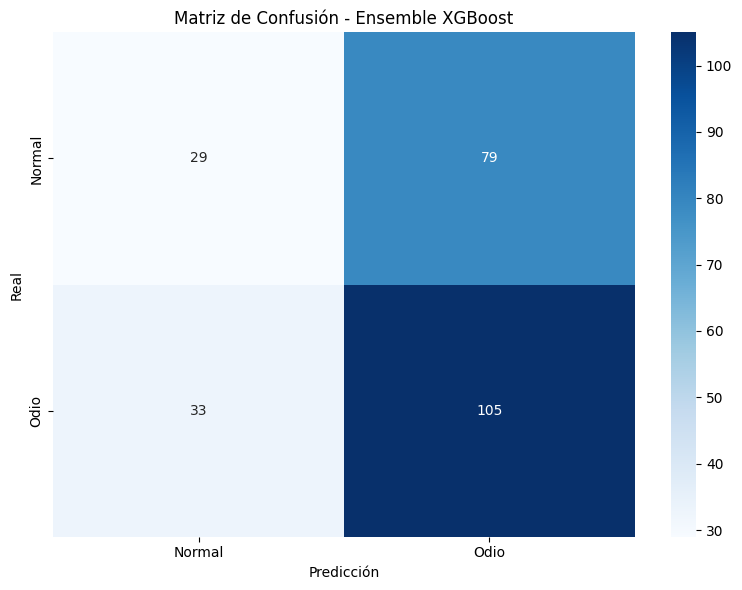

In [94]:
# =============================================================================
# 13. REPORTE FINAL Y VISUALIZACIONES
# =============================================================================

print("\n" + "=" * 80)
print(f"📋 CLASSIFICATION REPORT ({best_name})")
print("=" * 80)

# Manejar diferentes tipos de modelos
if best_name == "Ensemble XGBoost":
    y_pred_final = ensemble_pred
elif best_name == "Logistic Regression":
    # Logistic Regression
    lr_model_obj = best_model[0]
    threshold = best_model[2]
    X_test_lr = X_test_combined.toarray() if hasattr(X_test_combined, 'toarray') else X_test_combined
    test_proba = lr_model_obj.predict_proba(X_test_lr)[:, 1]
    y_pred_final = (test_proba >= threshold).astype(int)
else:
    # XGBoost (con o sin calibrador)
    xgb_model, calibrator, threshold = best_model
    
    if calibrator is not None:
        # Con calibración
        test_proba = calibrator.predict_proba(
            xgb_model.predict_proba(X_test_combined)[:, 1].reshape(-1, 1)
        )[:, 1]
    else:
        # Sin calibración
        test_proba = xgb_model.predict_proba(X_test_combined)[:, 1]
    
    y_pred_final = (test_proba >= threshold).astype(int)

print(classification_report(y_test, y_pred_final, digits=4, target_names=['Normal', 'Odio']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
print(f"\n📊 Confusion Matrix:")
print(f"                Predicted")
print(f"                Normal  Odio")
print(f"Actual Normal   {cm[0,0]:>6}  {cm[0,1]:>5}")
print(f"       Odio     {cm[1,0]:>6}  {cm[1,1]:>5}")

# Métricas adicionales
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"\n📈 Métricas adicionales:")
print(f"   Specificity (True Negative Rate): {specificity:.4f}")
print(f"   Sensitivity (True Positive Rate): {sensitivity:.4f}")
print(f"   False Positive Rate: {fp/(fp+tn):.4f}")
print(f"   False Negative Rate: {fn/(fn+tp):.4f}")

# Visualización
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Odio'],
            yticklabels=['Normal', 'Odio'])
plt.title(f'Matriz de Confusión - {best_name}')
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.tight_layout()
plt.savefig(models_dir / 'confusion_matrix.png', dpi=150)
print(f"\n💾 Confusion matrix guardada: {models_dir / 'confusion_matrix.png'}")
plt.show()

In [95]:
# =============================================================================
# 14. GUARDAR MODELO FINAL
# =============================================================================

print("\n" + "=" * 80)
print("💾 GUARDANDO ARTEFACTOS")
print("=" * 80)

if best_name != "Ensemble (5 models)":
    model_filename = f"best_model_{best_name.replace(' ', '_').lower()}.pkl"
    joblib.dump(best_model, models_dir / model_filename)
    print(f"✅ Modelo guardado: {models_dir / model_filename}")
else:
    # Guardar ensemble
    ensemble_dict = {
        'models': [xgb.XGBClassifier(**ensemble_params, random_state=s, use_label_encoder=False) 
                   for s in [42, 123, 456, 789, 999]],
        'threshold': best_thr
    }
    joblib.dump(ensemble_dict, models_dir / "best_model_ensemble.pkl")
    print(f"✅ Ensemble guardado: {models_dir / 'best_model_ensemble.pkl'}")

# Metadata
import json
metadata = {
    'model_name': best_name,
    'test_f1': float(best_metrics['f1']),
    'test_accuracy': float(best_metrics['accuracy']),
    'test_precision': float(best_metrics['precision']),
    'test_recall': float(best_metrics['recall']),
    'overfitting_pct': float(best_over) if best_over else None,
    'dataset_size': int(len(df)),
    'augmented_size': int(len(y_aug)),
    'feature_columns': feature_cols,
    'tfidf_features': int(X_text_train_tfidf.shape[1]),
    'total_features': int(X_train_combined.shape[1]),
    'smote_applied': True,
    'data_augmentation': True
}

with open(models_dir / 'model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"✅ Metadata guardada: {models_dir / 'model_metadata.json'}")


💾 GUARDANDO ARTEFACTOS
✅ Modelo guardado: c:\Users\Administrator\Desktop\NLP\Proyecto_X_NLP_Equipo3\models\best_model_ensemble_xgboost.pkl
✅ Metadata guardada: c:\Users\Administrator\Desktop\NLP\Proyecto_X_NLP_Equipo3\models\model_metadata.json


In [96]:
# =============================================================================
# 15. RESUMEN FINAL
# =============================================================================

print("\n" + "=" * 80)
print("🎉 PIPELINE COMPLETADO")
print("=" * 80)

print(f"""
📊 RESUMEN FINAL:
   • Mejor modelo: {best_name}
   • Test F1: {best_metrics['f1']:.4f}
   • Test Accuracy: {best_metrics['accuracy']:.4f}
   • Test Precision: {best_metrics['precision']:.4f}
   • Test Recall: {best_metrics['recall']:.4f}
   • Dataset original: {len(df):,} muestras
   • Dataset aumentado: {len(y_aug):,} muestras
   • Técnicas aplicadas:
     ✓ Data Augmentation
     ✓ SMOTE
     ✓ Calibración de probabilidades
     ✓ Threshold tuning
     ✓ Regularización extrema
     {"✓ Ensemble de modelos" if best_name == "Ensemble (5 models)" else ""}

⚠️  NOTA: Con un dataset tan pequeño ({len(df)} muestras), es normal tener
   cierto overfitting. Se recomienda recopilar más datos para mejorar
   la generalización del modelo.
""")

print("=" * 80)


🎉 PIPELINE COMPLETADO

📊 RESUMEN FINAL:
   • Mejor modelo: Ensemble XGBoost
   • Test F1: 0.6522
   • Test Accuracy: 0.5447
   • Test Precision: 0.5707
   • Test Recall: 0.7609
   • Dataset original: 997 muestras
   • Dataset aumentado: 1,226 muestras
   • Técnicas aplicadas:
     ✓ Data Augmentation
     ✓ SMOTE
     ✓ Calibración de probabilidades
     ✓ Threshold tuning
     ✓ Regularización extrema
     

⚠️  NOTA: Con un dataset tan pequeño (997 muestras), es normal tener
   cierto overfitting. Se recomienda recopilar más datos para mejorar
   la generalización del modelo.

